In [32]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import  RFE
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error

from scipy import stats


# Regression part for Breast Cancer dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_seq_items', 500)


### Reading data

In [33]:
#Load the dataset
df = pd.read_csv('TrainDataset2024.csv',index_col=False)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 121 columns):
 #    Column                                              Non-Null Count  Dtype  
---   ------                                              --------------  -----  
 0    ID                                                  400 non-null    object 
 1    pCR (outcome)                                       400 non-null    int64  
 2    RelapseFreeSurvival (outcome)                       400 non-null    float64
 3    Age                                                 400 non-null    float64
 4    ER                                                  400 non-null    int64  
 5    PgR                                                 400 non-null    int64  
 6    HER2                                                400 non-null    int64  
 7    TrippleNegative                                     400 non-null    int64  
 8    ChemoGrade                                          400 non-null    

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,Gene,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e

### DATA PRE-PROCESSING

In [34]:
print ("data size before removing missing values: ", df.shape)
missing_values_index = np.where(df.isin([999]) == True)
missing_values_index = np.array(missing_values_index).tolist()
missing_values_index = set(missing_values_index[0])

drop_index = []
for index in missing_values_index:
    missing_values_rows = df.iloc[index]
    missing_values_rows = np.array(missing_values_rows).tolist()
    if missing_values_rows.count(999) >= 4:
        drop_index.append(index)

df = df.drop(drop_index)

# retain the original dataset with ID column to be used in the future
dataset_ID = df['ID']
df.drop('ID', axis=1, inplace=True)
print ("data size after removing missing values: ", df.shape)

data size before removing missing values:  (400, 121)
data size after removing missing values:  (398, 120)


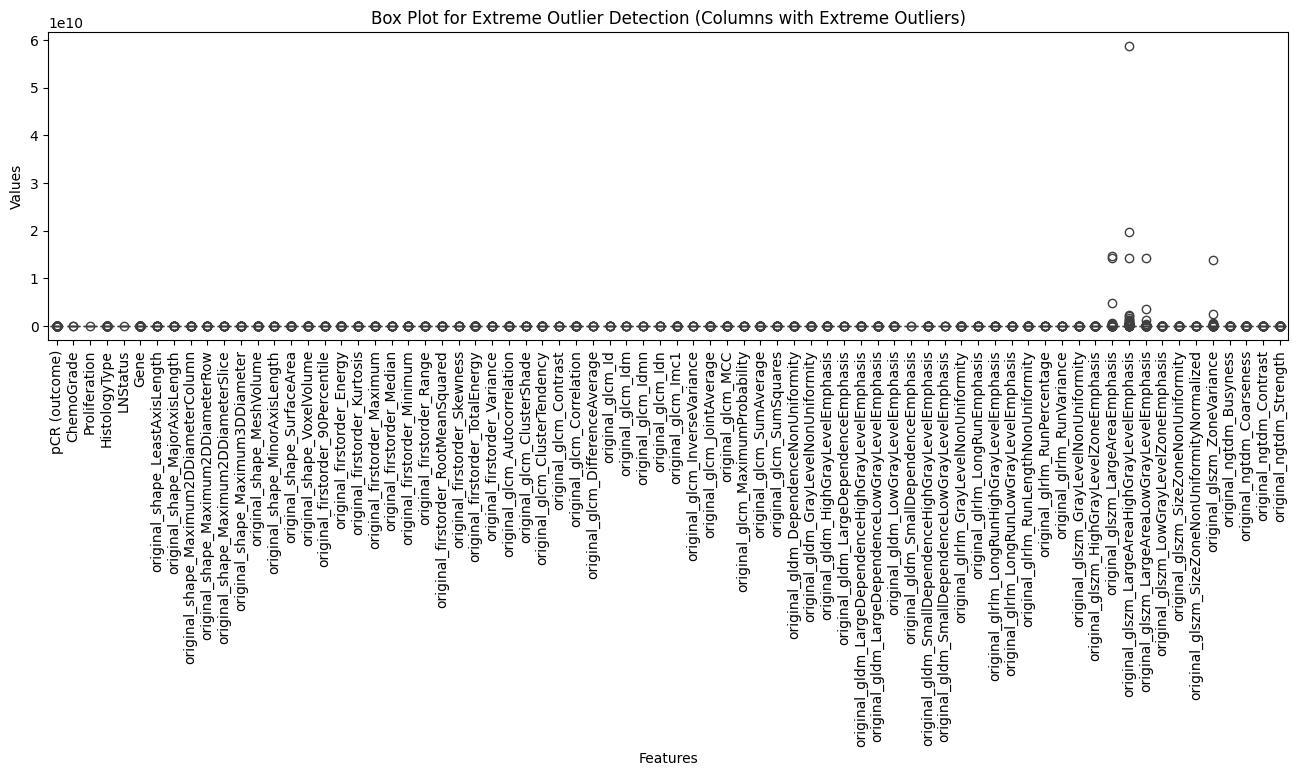

In [35]:
# Identify outliers using the 25th and 75th percentiles
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define extreme outliers
extreme_outliers = ((df < (Q1 - 3 * IQR)) | (df > (Q3 + 3 * IQR)))

# Filter columns with extreme outliers
extreme_outlier_columns = df.columns[extreme_outliers.any()]

# Filter the DataFrame to include only columns with extreme outliers
df_extreme_outliers = df[extreme_outlier_columns]

# Plot boxplot for columns with extreme outliers
plt.figure(figsize=(16, 4))
sns.boxplot(data=df_extreme_outliers)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.title("Box Plot for Extreme Outlier Detection (Columns with Extreme Outliers)")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

In [36]:
column_checks = df.isin([999]).any()
print("Missing value exists in each column:\n", column_checks)

Missing value exists in each column:
 pCR (outcome)                     True
RelapseFreeSurvival (outcome)    False
Age                              False
ER                               False
PgR                              False
                                 ...  
original_ngtdm_Busyness          False
original_ngtdm_Coarseness        False
original_ngtdm_Complexity        False
original_ngtdm_Contrast          False
original_ngtdm_Strength          False
Length: 120, dtype: bool


In [37]:
# Count the number of values equal to 999 in all the columns before imputer
count_999 = (df.iloc[:, :] == 999).sum().sum()
print(f"Number of values equal to 999 in all columns before imputer is : {count_999}")

# Replace 999 with NaN
new_df = df.replace(999, np.NaN)
column_names = new_df.columns

# Perform iterative imputation
multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# Create a mask of the imputed values
imputed_mask = np.isnan(new_df.values)

# Round only the imputed values
multi_imputed_array[imputed_mask] = np.round(multi_imputed_array[imputed_mask])

# Convert to DataFrame
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# Get the target and features dataframe
regression_target = multi_imputed_df['RelapseFreeSurvival (outcome)']
regression_features = multi_imputed_df.drop(['RelapseFreeSurvival (outcome)', 'pCR (outcome)'], axis=1)

# Count the number of values equal to 999 in all the columns after imputer
count_999 = (multi_imputed_df.iloc[:, :] == 999).sum().sum()
print(f"Number of values equal to 999 in all columns after imputer is : {count_999}")

Number of values equal to 999 in all columns before imputer is : 97
Number of values equal to 999 in all columns after imputer is : 0


In [38]:
# Assuming regression_features and regression_target are already defined

# Step 1: Handle Outliers
z_scores = np.abs(stats.zscore(regression_features))
filtered_entries = (z_scores < 3).all(axis=1)
regression_features_filtered = regression_features[filtered_entries]
regression_target_filtered = regression_target[filtered_entries]

# Step 2: Feature Selection using RFE
rf = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=20)
rfe.fit(regression_features_filtered, regression_target_filtered)
selected_features_rfe = rfe.transform(regression_features_filtered)

# Step 3: Feature Engineering - Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True)
regression_features_poly = poly.fit_transform(selected_features_rfe)

# Step 4: Data Normalization
scaler = StandardScaler()
regression_features_scaled = scaler.fit_transform(regression_features_poly)

# Step 5: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(regression_features_scaled, regression_target_filtered)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best MAE: {-grid_search.best_score_}")

# Step 6: Train the final model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(regression_features_scaled, regression_target_filtered)

# Step 7: Evaluate the model using cross-validation
scores = cross_val_score(best_rf, regression_features_scaled, regression_target_filtered, cv=5, scoring='neg_mean_absolute_error')
print(f"Mean MAE with selected features and best parameters: {-scores.mean()}")

# Step 8: Train-test split to check MAE on test set
X_train, X_test, y_train, y_test = train_test_split(regression_features_scaled, regression_target_filtered, test_size=0.2, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on test set: {mae}")

Best parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best MAE: 23.03975180253857
Mean MAE with selected features and best parameters: 23.03975180253857
MAE on test set: 21.12190711281137


### Feature Selection 

In [39]:
features_to_be_selected = 20


P-value less than <= 0.05 indicates significant dependency between values

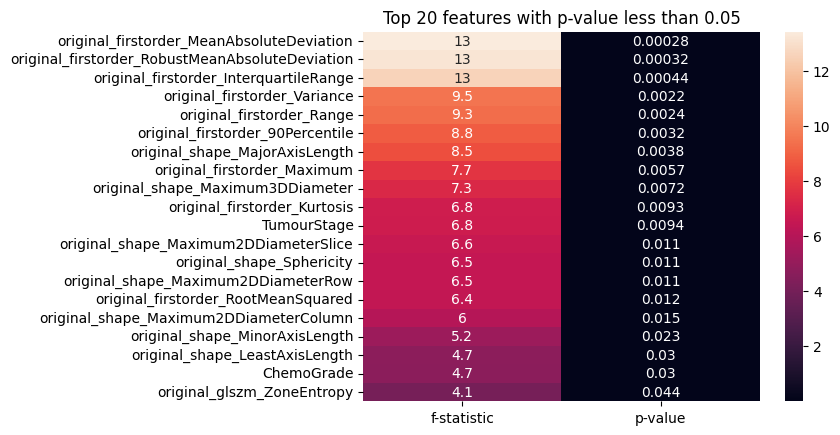

In [40]:
f, p_val = f_regression(regression_features, regression_target)
f_reg_df = pd.DataFrame(np.array([f, p_val]).T, index=regression_features.columns, columns=['f-statistic', 'p-value'])
binary_stored_features = f_reg_df[f_reg_df['p-value'] <= 0.05].sort_values(by='f-statistic', ascending=False).head(
    features_to_be_selected)
sns.heatmap(data=binary_stored_features, annot=True)
plt.title(f'Top {len(binary_stored_features)} features with p-value less than 0.05')
plt.show()
binary_stored_features = binary_stored_features.head(20)

Mutual info to find best features

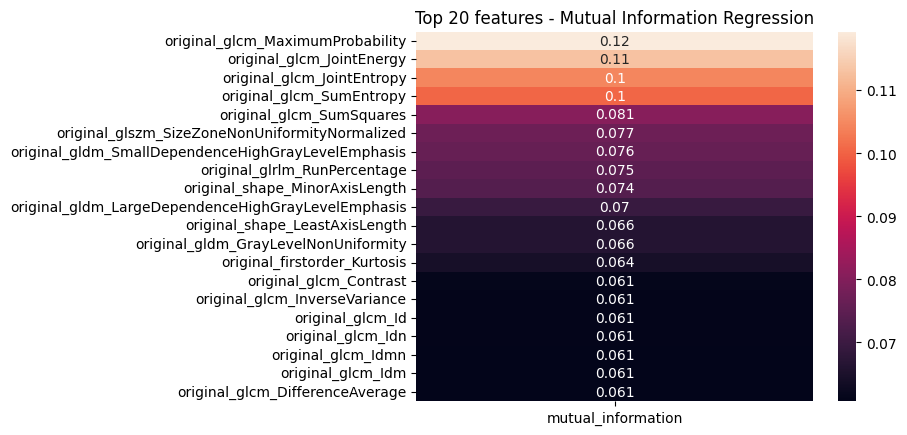

In [41]:
mi = mutual_info_regression(regression_features, regression_target, random_state=42)
mi_df = pd.DataFrame(mi, index=regression_features.columns, columns=['mutual_information'])
mi_top_features = mi_df.sort_values(by=['mutual_information'], ascending=False).head(features_to_be_selected)
sns.heatmap(mi_top_features, annot=True)
plt.title(f'Top {features_to_be_selected} features - Mutual Information Regression')
plt.show()
mi_top_features = mi_top_features.head(10)

In [42]:
# hyperparameters grid search
rf = RandomForestRegressor()
rf_search = GridSearchCV(rf, param_grid={
    'n_estimators': np.arange(200, 500, 100).tolist(),
    'max_features': ['sqrt'],
    'random_state': [42],
    'criterion': ['absolute_error'],
    'max_depth': np.arange(5, 15, 1).tolist()}, scoring='neg_mean_absolute_error')
rf_search.fit(regression_features, regression_target)
print("Best params for Random Forest Regressor: ", rf_search.best_params_)
print("Best parameter (Cross-validation MAE): ", rf_search.best_score_, "\n")

Best params for Random Forest Regressor:  {'criterion': 'absolute_error', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 300, 'random_state': 42}
Best parameter (Cross-validation MAE):  -22.663288981102575 



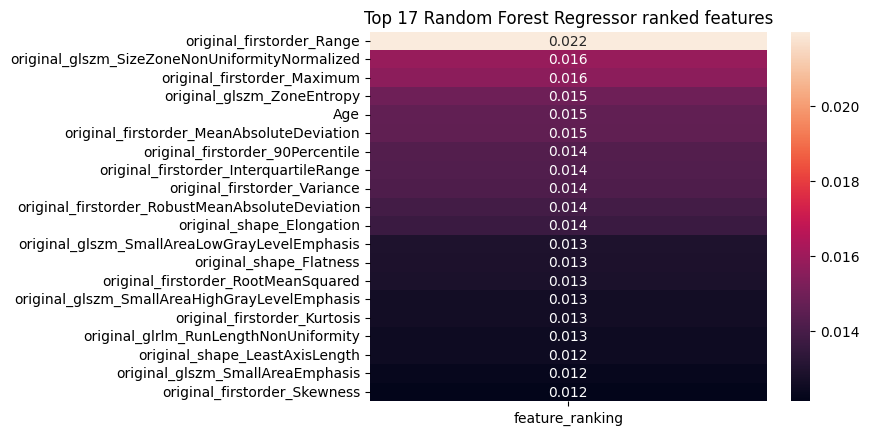

In [43]:
# rank features using random forest
rf = make_pipeline(StandardScaler(),
                   RandomForestRegressor().set_params(**rf_search.best_params_))
rf.fit(regression_features, regression_target)
rf_features = pd.DataFrame(rf.steps[1][1].feature_importances_, index=regression_features.columns,
                           columns=['feature_ranking'])
selected_rf_features = rf_features.sort_values(by=['feature_ranking'], ascending=False).head(features_to_be_selected)
sns.heatmap(data=selected_rf_features, annot=True)
plt.title('Top 17 Random Forest Regressor ranked features')
plt.show()
selected_rf_features = selected_rf_features.head(6)

In [44]:
# Ensure ER, HER2, and Gene are retained
important_features = ['ER', 'HER2', 'Gene']

# Combine the important features with the features selected by statistical methods
selected_features = np.concatenate(
    (important_features, binary_stored_features.index.values, selected_rf_features.index.values, mi_top_features.index.values,regression_features.columns[rfe.support_]))

# Remove duplicates (if any) and select the final set of features
selected_features = set(selected_features)
selected_features = list(selected_features)

# Update the features used in the model
top_features = regression_features[selected_features]


print(selected_features)
print(len(selected_features))

['original_shape_Maximum2DDiameterColumn', 'original_firstorder_90Percentile', 'original_glcm_JointEntropy', 'original_glcm_Imc1', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_firstorder_Minimum', 'original_glrlm_RunPercentage', 'original_firstorder_Variance', 'ChemoGrade', 'original_shape_LeastAxisLength', 'original_shape_Maximum2DDiameterSlice', 'TumourStage', 'original_shape_Sphericity', 'original_glszm_SizeZoneNonUniformity', 'original_firstorder_Range', 'original_glcm_SumEntropy', 'original_firstorder_RootMeanSquared', 'original_shape_Maximum2DDiameterRow', 'original_glcm_JointEnergy', 'Gene', 'original_gldm_DependenceNonUniformityNormalized', 'original_glszm_SmallAreaHighGrayLevelEmphasis', 'original_shape_Maximum3DDiameter', 'original_firstorder_MeanAbsoluteDeviation', 'original_shape_MinorAxisLength', 'original_glszm_ZoneEntropy', 'original_glcm_MaximumProbability', 'original_firstorder_10Percentile', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'orig

### Split Train and Test data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(top_features, regression_target, test_size=0.3, random_state=42)


### Evaluate Models (Tuning Hyperparameters with Grid Search)

### SVR

In [46]:
top_features_svr = make_pipeline(StandardScaler(), SVR())
top_features_svr_search = GridSearchCV(top_features_svr,
                                       param_grid={'svr__C': np.arange(0, 10, 0.1).tolist(),
                                                   'svr__epsilon': np.arange(0, 3, 0.1).tolist()},
                                       scoring='neg_mean_absolute_error',
                                       )
top_features_svr_search.fit(X_train, y_train)
print("Best params for SVR: ", top_features_svr_search.best_params_)
print("Best parameter (Cross-validation MAE): ", top_features_svr_search.best_score_, "\n")

grid_keys = list(top_features_svr_search.best_params_.keys())
param_keys = [param.replace('svr__', '') for param in grid_keys]
grid_values = list(top_features_svr_search.best_params_.values())
param_dict_svr = {k: v for k, v in zip(param_keys, grid_values)}

top_features_svr = make_pipeline(StandardScaler(), SVR().set_params(**param_dict_svr))
top_features_svr.fit(X_train, y_train)
print("Mean absolute error for svm test score: ",
      mean_absolute_error(y_test, top_features_svr.predict(X_test)))
print("Mean absolute error for svm cross-validation score: ",
      np.mean(cross_val_score(top_features_svr, X_train, y_train, scoring='neg_mean_absolute_error')))

Best params for SVR:  {'svr__C': 8.700000000000001, 'svr__epsilon': 2.9000000000000004}
Best parameter (Cross-validation MAE):  -20.47193616995508 

Mean absolute error for svm test score:  22.12215193929716
Mean absolute error for svm cross-validation score:  -20.47193616995508


### Random Forest Regressor

In [47]:
top_features_rr = make_pipeline(StandardScaler(), RandomForestRegressor())
top_features_rr_search = GridSearchCV(top_features_rr, param_grid={
    'randomforestregressor__n_estimators': np.arange(200, 500, 100).tolist(),
    'randomforestregressor__max_features': ['sqrt', 'auto', 'log2'],
    'randomforestregressor__random_state': [42],
    'randomforestregressor__criterion': ['absolute_error'],
    'randomforestregressor__max_depth': np.arange(5, 15, 1).tolist()}, verbose=3, scoring='neg_mean_absolute_error')
top_features_rr_search.fit(X_train, y_train)
print("Best params for Random Forest Regressor: ", top_features_rr_search.best_params_)
print("Best parameter (Cross-validation MAE): ", top_features_rr_search.best_score_, "\n")

grid_keys = list(top_features_rr_search.best_params_.keys())
param_keys = [param.replace('randomforestregressor__', '') for param in grid_keys]
grid_values = list(top_features_rr_search.best_params_.values())
param_dict_rr = {k: v for k, v in zip(param_keys, grid_values)}

top_features_rr = make_pipeline(StandardScaler(),
                                RandomForestRegressor().set_params(**param_dict_rr))
top_features_rr.fit(X_train, y_train)
print("Mean absolute error for random forest test score: ",
      mean_absolute_error(y_test, top_features_rr.predict(X_test)))
print("Mean absolute error for random forest cross-validation score: ", np.mean(cross_val_score(top_features_rr, X_train, y_train, scoring='neg_mean_absolute_error')))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__random_state=42;, score=-20.566 total time=   0.3s
[CV 2/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__random_state=42;, score=-17.495 total time=   0.3s
[CV 3/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimators=200, randomforestregressor__random_state=42;, score=-21.563 total time=   0.3s
[CV 4/5] END randomforestregressor__criterion=absolute_error, randomforestregressor__max_depth=5, randomforestregressor__max_features=sqrt, randomforestregressor__n_estimato

### Lasso

In [48]:
lasso = make_pipeline(StandardScaler(), Lasso())
lasso_search = GridSearchCV(lasso, param_grid={'lasso__alpha': np.arange(0, 10000, 100).tolist()},
                            scoring='neg_mean_absolute_error')
lasso_search.fit(X_train, y_train)
print("Best params for Lasso Regression: ", lasso_search.best_params_)
print("Best parameter (Cross-validation MAE): ", lasso_search.best_score_, "\n")

grid_keys = list(lasso_search.best_params_.keys())
param_keys = [param.replace('lasso__', '') for param in grid_keys]
grid_values = list(lasso_search.best_params_.values())
param_dict_lasso = {k: v for k, v in zip(param_keys, grid_values)}

lasso = make_pipeline(StandardScaler(), Lasso().set_params(**param_dict_lasso))
lasso.fit(X_train, y_train)

print("Mean absolute error for Lasso Regression test score: ",
      mean_absolute_error(y_test, lasso.predict(X_test)))
print("Mean absolute error for Lasso Regression cross-validation score: ",
      np.mean(cross_val_score(lasso, X_train, y_train, scoring='neg_mean_absolute_error')))

Best params for Lasso Regression:  {'lasso__alpha': 100}
Best parameter (Cross-validation MAE):  -21.124440765781685 

Mean absolute error for Lasso Regression test score:  21.528357314395084
Mean absolute error for Lasso Regression cross-validation score:  -21.124440765781685


### XGBOOST

In [49]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define the model
xgb = XGBRegressor()

# Define parameter grid
xgb_search = GridSearchCV(
    xgb,
    param_grid={
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    scoring='neg_mean_absolute_error',
    cv=5
)

# Perform grid search
xgb_search.fit(X_train, y_train)

# Display best parameters and corresponding cross-validation score
print("Best params for XGBoost Regression: ", xgb_search.best_params_)
print("Best parameter (Cross-validation MAE): ", xgb_search.best_score_, "\n")

# Apply best parameters
xgb.set_params(**xgb_search.best_params_)
xgb.fit(X_train, y_train)

# Evaluate XGBoost on the test set and using cross-validation
print("Mean absolute error for XGBoost Regression test score: ",
      mean_absolute_error(y_test, xgb.predict(X_test)))
print("Mean absolute error for XGBoost Regression cross-validation score: ",
      np.mean(cross_val_score(xgb, X_train, y_train, scoring='neg_mean_absolute_error')))


Best params for XGBoost Regression:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Best parameter (Cross-validation MAE):  -20.28442165675229 

Mean absolute error for XGBoost Regression test score:  22.997028170830486
Mean absolute error for XGBoost Regression cross-validation score:  -20.28442165675229


# Best ML model selection

In [50]:
rf = RandomForestRegressor().set_params(**param_dict_rr)
Xs = StandardScaler().fit_transform(top_features)
rf.fit(Xs, regression_target)

RandomForestRegressor(criterion='absolute_error', max_depth=12,
                      max_features='log2', n_estimators=200, random_state=42)

In [51]:
xgboost =  XGBRegressor().set_params(**xgb_search.best_params_)
Xs = StandardScaler().fit_transform(top_features)
xgboost.fit(Xs, regression_target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
svr = SVR().set_params(**param_dict_svr)
Xs = StandardScaler().fit_transform(top_features)
svr.fit(Xs, regression_target)

SVR(C=8.700000000000001, epsilon=2.9000000000000004)

In [53]:
lasso = Lasso().set_params(**param_dict_lasso)
Xs = StandardScaler().fit_transform(top_features)
lasso.fit(Xs, regression_target)


Lasso(alpha=100)

### Predictions

In [54]:
predictions = rf.predict(X_test)
print("mean_absolute_error Random Forest Regressor",mean_absolute_error(y_test,predictions))

predictions = xgboost.predict(X_test)
print("mean_absolute_error XGBOOST : ",mean_absolute_error(y_test,predictions))

predictions = svr.predict(X_test)
print("mean_absolute_error SVR :",mean_absolute_error(y_test,predictions))


predictions = lasso.predict(X_test)
print("mean_absolute_error Lasso :",mean_absolute_error(y_test,predictions))


mean_absolute_error Random Forest Regressor 21.70109895849521
mean_absolute_error XGBOOST :  23.603017563428956
mean_absolute_error SVR : 21.496141704952574
mean_absolute_error Lasso : 21.531602456976973


In [55]:
import pickle

In [ ]:
with open("svr_test.pickle", "wb") as f:
    pickle.dump(rf, f)